# Distribution of True Stellar Rotational Velocities

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps

import scipy.stats as stats
import scipy.integrate as integrate
from scipy.interpolate import CubicSpline

Where the variable $x \equiv v$ is the true rotational velocity, and $y \equiv v \sin i$ is the projected rotational velocity. The variable $x$ follows a distribution $f_X(x)$, and the variable $y$ follows a distribution $f_Y(y)$. The parameter $\alpha$ is a constant that depends on the specific characteristics of the system being modeled.

The function designed in this proyect is

$$f_Y(y) = \int_y^\infty \frac{y^{2\alpha+1}}{x^{2\alpha+1}} \frac{1}{\sqrt{x^2 + y^2}} f_X(x) \, dx$$

In [2]:
# Load the datasets
gendata = pd.read_csv('data/geneve.dat', header=None)
gendata.columns = ['vsini']

In [3]:
gendata.describe()

,vsini
count,11818.000000
mean,7.725503
std,6.391010
min,0.000000
25%,3.000000
50%,6.000000
75%,10.000000
max,29.000000


In [4]:
gendata.min(), gendata.max()

(vsini    0
 dtype: int64,
 vsini    29
 dtype: int64)

By expert knowledge, we know that any star has a rotational velocity $v \leq 0$ km/s. Therefore, we have to remove the values where this condition is met.

In [5]:
print("Gendata vsini <= 0 count:",gendata[gendata.vsini <=0].vsini.count())
gendata = gendata[gendata.vsini > 0]

Gendata vsini <= 0 count: 133


First we will create the Kernel Density Estimation (KDE) function for the given $v \sin{i}$ data points, that represents the projected rotational velocities of stars. The KDE function will help us estimate the probability density function of the data $f_Y(y)$.

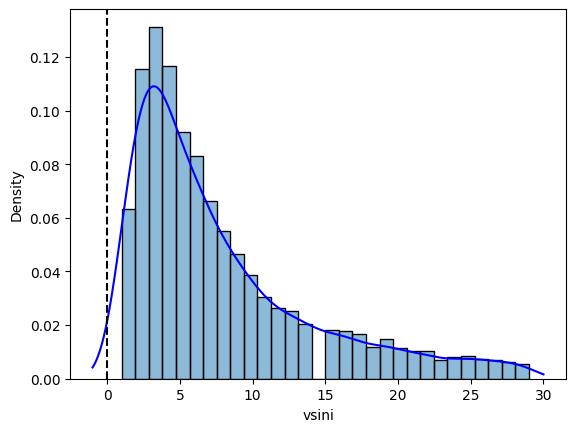

In [6]:
kde = stats.gaussian_kde(gendata.vsini, bw_method='silverman')
vsinimax, vsinimin = gendata.vsini.max(), gendata.vsini.min()
vsinirange = np.linspace(vsinimin-2, vsinimax+1, 1000)

fig, ax = plt.subplots()

ax.plot(vsinirange, kde(vsinirange), label='Gendata KDE', color='blue')
sns.histplot(gendata.vsini, bins=30, stat='density', alpha=0.5, label='Gendata Histogram', ax=ax)
ax.axvline(0.0, color='black', linestyle='--')

As we can see in the KDE plot below, the projected rotational velocities are distributed between $0$ km/s and approximately $30$ km/s, with a peak around $3$ km/s. But the KDE does not begins exactly at $0$ km/s, so we will use a technique called "reflection" to ensure that the KDE starts at $0$ km/s. This technique involves reflecting the data points around the boundary (0 km/s in this case) to create a symmetric distribution.

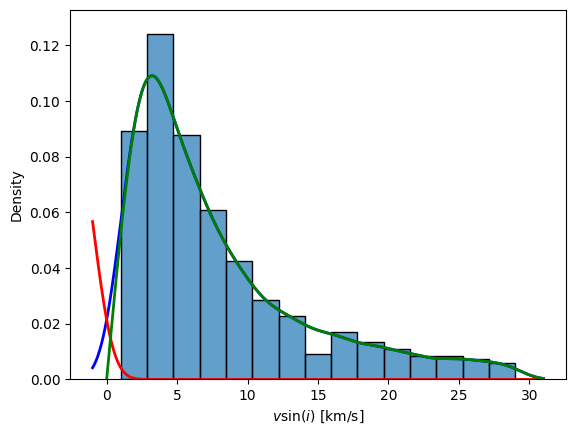

In [7]:
kdeplus = stats.gaussian_kde(dataset=gendata.vsini,bw_method='silverman')
kdenegs = stats.gaussian_kde(dataset=-gendata.vsini,bw_method='silverman')

vsinimax, vsinimin = max(gendata.vsini)+2, min(gendata.vsini-2)
vsinirange = np.linspace(start=vsinimin, stop=vsinimax, num=1000)
kdeplus_values = kdeplus.evaluate(vsinirange)
kdenegs_values = kdenegs.evaluate(vsinirange)

# This function computes the difference between the two gaussian KDEs.
# This KDE represents the estimated vsini distribution corrected for
# the observational bias towards positive values. Taking the negative
# KDE into account helps to mitigate the skewness introduced by the
# fact that vsini values cannot be negative.
kde = lambda x: kdeplus.evaluate(x) - kdenegs.evaluate(x)

fig, ax = plt.subplots()
ax.plot(vsinirange,kdeplus_values,color='blue',lw=2,label='KDE (Silverman)')
ax.plot(vsinirange,kdenegs_values,color='red',lw=2,label='KDE (Silverman)')
ax.plot(vsinirange,kde(vsinirange),color='green',lw=2,label='KDE Difference')
sns.histplot(
    data=gendata,
    x='vsini',
    bins=15,
    stat='density',
    edgecolor='black',
    alpha=0.7,
    ax=ax
)
ax.set_ylabel('Density')
ax.set_xlabel(r'$v\sin(i)$ [km/s]')
plt.ylim(0, None)
plt.show()

Now we will create a meshgrid for the variables $x$ and $y$. The meshgrid will allow us to evaluate the integral for a range of values of $x$ and $y$.

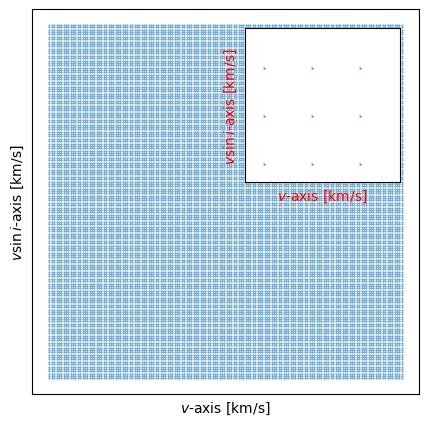

In [8]:
N = 150
a, b = 0.1, gendata.vsini.max()+5
dx = (b - a)/N
dy = (b - a + dx/2)/N
x = a + dx * (np.arange(N)-0.05)
y = a + dy * (np.arange(N)-0.05)

xx, yy = np.meshgrid(x, y)

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(xx, yy, s=1, marker='.', alpha=0.7)
ax.axis('equal')
ax.set_xlabel(r'$v$-axis [km/s]')
ax.set_ylabel(r'$v\sin{i}$-axis [km/s]')
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticklabels([])
axins = ax.inset_axes([0.55, 0.55, 0.4, 0.4], xlim=(0, dx+0.5), ylim=(0, dy+0.5))
axins.scatter(xx, yy, s=1, marker='.')
axins.set_xlabel(r'$v$-axis [km/s]',color='red')
axins.set_ylabel(r'$v\sin{i}$-axis [km/s]', color='red')
axins.set_yticklabels([])
axins.set_xticklabels([])
axins.set_xticks([])
axins.set_yticks([])
plt.show()

Recall the objective equation:
$$f_Y(y) = c_\alpha\int_y^\infty \frac{y^{2\alpha+1}}{x^{2\alpha+1}} \frac{1}{\sqrt{x^2 - y^2}} f_X(x) \, dx$$

We caan use a matrix form to represent the integral equation. We will discretize the integral by evaluating it at the meshgrid points.

$$\underbrace{f_Y(y)}_{\mathbf{Y}} = \underbrace{c_\alpha\int_y^\infty dx \frac{y^{2\alpha+1}}{x^{2\alpha+1}} \frac{1}{\sqrt{x^2 - y^2}}}_{\mathbf{A}}  \, \underbrace{f_X(x)}_{\mathbf{X}} $$

Now we will using the matrix form for our objetive equation: 
$$Y = AX$$

where $Y = f_Y(y)$, $X = f_X(x)$, and $A$ is the matrix that contains the values of the integrand evaluated at the meshgrid points.

Now we will solve for $X$ using the pseudo-inverse of matrix $A$:
$$X = A^{-1}Y$$

First we will create the A matrix by evaluating the integrand at the meshgrid points. Then we will compute the pseudo-inverse of matrix $A$ using the Singular Value Decomposition (SVD) method. So we also create a vector of $\alpha$ values to evaluate the integrand for different $\alpha$ values.

Finally, we will multiply the pseudo-inverse of matrix $A$ with the KDE values $Y$ to obtain the estimated distribution of true stellar rotational velocities $X = f_X(x)$.

In [9]:
# Create an array of alpha values
alphas = np.linspace(-0.5, 2.0, 10)
alphas = alphas[:, None, None]

# This mask is created to obtain just real values where y=vsin(i)<=v=x
mask = yy < xx

ratio_grid = np.zeros_like(xx)
geom_grid  = np.zeros_like(xx)

ratio_grid[mask] = (yy[mask]/xx[mask])
geom_grid[mask]  = 1/np.sqrt(xx[mask]**2-yy[mask]**2)

A = (ratio_grid[None, :, :]**(2*alphas+1)) * geom_grid[None, :, :]
print("A shape:", A.shape)

A shape: (10, 150, 150)


Now we will obtain the _Probability Density Function_ (PDF) of the projected rotational velocities $f_Y(y)$ using the KDE function created earlier. Then, we will use the pseudo-inverse of matrix $A$ to compute the estimated distribution of true stellar rotational velocities $f_X(x)$.

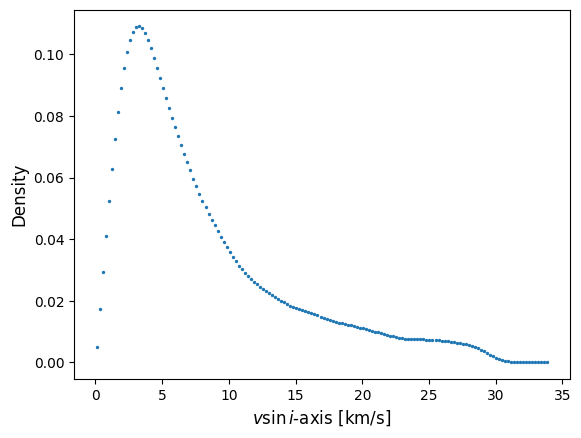

In [10]:
fyy = kde(y)
fig, ax = plt.subplots()
ax.scatter(y.flatten(), fyy, s=2)
ax.set_xlabel(r'$v\sin{i}$-axis [km/s]', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
plt.show()

Now we solve for $X$ using the pseudo-inverse of matrix $A$:

$$\hat X = (A^\top A+\lambda I)^{-1}A^\top Y$$

In [11]:
print("fyy shape:", fyy.shape)
#print("fyy reshape",)
#print("fyy added axis shape:", fyy.reshape(N,N)[None, :, :].shape)
print("A shape for solving:", A.shape)

fxx = np.zeros((len(alphas), N))
tiklambda = 0.01
Idnt = np.eye(N)
for i in range(len(alphas)):
    A_curr = A[i]
    LHS = A_curr.T @ A_curr + tiklambda * Idnt
    RHS = A_curr.T @ fyy
    
    try:
        fxx[i] = np.linalg.solve(LHS, RHS)
    except np.linalg.LinAlgError:
        print(f"LinAlgError at alpha index {i}, alpha value {alphas[i,0]}")
        fxx[i], _, _, _ = np.linalg.lstsq(LHS, RHS, rcond=None)

print("Shape de la solución fxx:", fxx.shape) # Debería ser (10, 150)

fyy shape: (150,)
A shape for solving: (10, 150, 150)
Shape de la solución fxx: (10, 150)


In [12]:
fxx_inter = CubicSpline(x=x, y=fxx, axis=1)(x)
fxx_inter.shape

cte = integrate.simpson(fxx_inter, x, axis=1)
fxx_inter = fxx_inter / cte[:, None]

Now we want to reconstruct the projected rotational velocities distribution $f_Y(y)$ using the estimated true rotational velocities distribution $f_X(x)$. Integrating the estimated $f_X(x)$ back into the original integral equation should yield a distribution that closely matches the original KDE of $f_Y(y)$.

In [25]:
fyy_recons = np.zeros((len(alphas), N))
for i in range(len(alphas)):
    A[i] * fxx_inter[i]
    fyy_recons[i] = integrate.trapezoid(A[i] * fxx_inter[i], x=x, axis=1)

In [26]:
fyy_recons.shape

(10, 150)

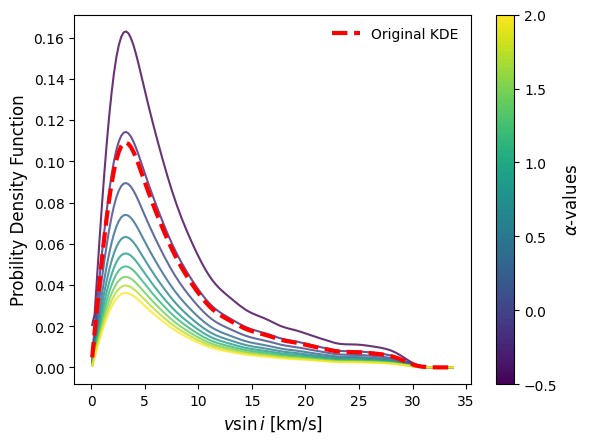

In [27]:
cmap = colormaps.get_cmap('viridis')
norm = plt.Normalize(vmin=alphas.min(), vmax=alphas.max())

# 2. Crear el objeto ScalarMappable que usará el colorbar
s_m = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
s_m.set_array(alphas) # Le decimos que valores numéricos representan el color

fig, ax = plt.subplots()
for i in range(len(alphas)):
    line_color = cmap(norm(alphas[i])).flatten()
    ax.plot(x, fyy_recons[i,:], color=line_color, alpha=0.8)
    
cbar = plt.colorbar(s_m, ax=ax)
cbar.set_label(r'$\alpha$-values', fontsize=12)
ax.plot(x, fyy, 'r--', lw=3, label='Original KDE')
ax.set_xlabel(r'$v\sin{i}$ [km/s]', fontsize=12)
ax.set_ylabel('Probility Density Function', fontsize=12)
plt.legend(frameon=False)
plt.show()

For see what is the best value of the parameter $\alpha$, we will use the RMSE (Root Mean Square Error) metric to compare the reconstructed $f_Y(y)$ with the original KDE of $f_Y(y)$. The value of $\alpha$ that minimizes the RMSE will be considered the best fit for the data.

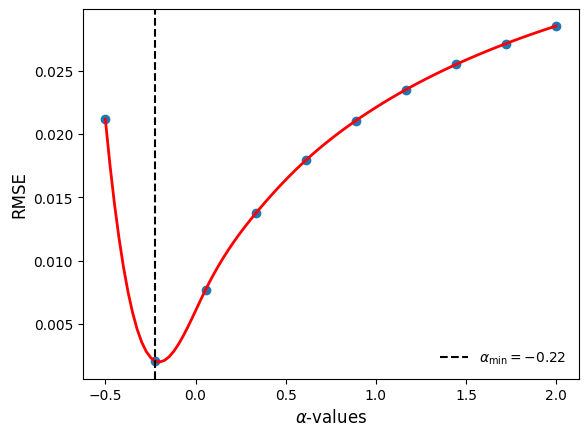

In [30]:
rmse = np.sqrt(np.mean((fyy_recons - fyy[None, :])**2, axis=1))
alins = np.linspace(alphas.min(), alphas.max(), 100)
rmse_smooth = CubicSpline(alphas.flatten(), rmse)(alins)

minidx = np.argmin(rmse)
fig, ax = plt.subplots()
ax.scatter(alphas.flatten(), rmse)
ax.plot(alins, rmse_smooth, 'r-', lw=2)
ax.set_xlabel(r'$\alpha$-values', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.axvline(
    alphas.flatten()[minidx], 
    color='black', 
    linestyle='--', 
    # Usamos un solo f-string para la cadena LaTeX y la variable
    label=f'$\\alpha_\\text{{min}}={alphas.flatten()[minidx]:.2f}$' 
)
ax.legend(frameon=False)
plt.show()